In [37]:
import numpy as np
import numpy.random as rn
import matplotlib.pyplot as plt  # to plot
import random
import matplotlib as mpl 

from hardwareModel import HardwareModel
import networkx as nx

from scipy import optimize       # to compare

import seaborn as sns
sns.set(context="talk", style="darkgrid", palette="hls", font="sans-serif", font_scale=1.05)

FIGSIZE = (19, 8)  #: Figure size, in inches!
mpl.rcParams['figure.figsize'] = FIGSIZE
rng = rn.default_rng()

In [38]:
def annealing(positions,
              edges,
              areas,
              interval,
              init_scale,
              maxsteps=10,
              debug=True):
    """ Optimize the black-box function 'cost_function' with the simulated annealing algorithm."""
    for i in range(len(positions)):
        state = init_positions(init_scale)
        positions[i] = state
    
    wireLengths = wirelengths(positions, edges)
    #print(np.sum(list(wireLengths.values())))
    cost = cost_function(wireLengths, positions, areas)
    states, costs = [[] for _ in range(len(positions))], [cost]
    optimalPos = positions.copy()
    minWireLengths = float("inf")
    best = wireLengths.copy()
    
    for step in range(maxsteps):
        fraction = step / float(maxsteps)
        T = temperature(fraction)

        for i in range(len(positions)):
            new_state = random_neighbour(positions[i], interval, areas[i] ** 0.5, fraction)
            positions[i] = new_state
            wireLengths = wirelengths(positions, edges)
            wireLengthSum = np.sum(list(wireLengths.values()))
            new_cost = cost_function(wireLengths, positions, areas)
            #if debug: print("Step #{:>2}/{:>2} : T = {:>4.3g}, state = {:>4.3g}, cost = {:>4.3g}, new_state = {:>4.3g}, new_cost = {:>4.3g} ...".format(step, maxsteps, T, state, cost, new_state, new_cost))
            if acceptance_probability(cost, new_cost, T) > rn.random():
                state, cost = new_state, new_cost
            if wireLengthSum < minWireLengths and overlapCost(positions, areas) == 0:
                minWireLengths = wireLengthSum
                optimalPos = positions.copy()
                best = wireLengths.copy()
                #print('wirelength:', minWireLengths, '|', 'pos:', optimalPos)
            
            states[i].append(state)
            costs.append(new_cost)
        #print("cost:", cost, "|", "new_cost:", new_cost)
        
        #print(np.sum(list(wireLengths.values())))
            # print("  ==> Accept it!")
        # else:
        #    print("  ==> Reject it...")

    print('wirelength:', minWireLengths, '|', 'overlap cost:', overlapCost(optimalPos, areas), '|', 'pos:', optimalPos)
        
    return state, cost_function(wireLengths, positions, areas), states, costs, minWireLengths, optimalPos, best

In [39]:
def wirelengths(x, e):
    repeats = set()
    output = {}

    for edge in e:
        if (edge[1], edge[0]) not in repeats:
            repeats.add(edge)
            position0 = x[edge[0]]
            position1 = x[edge[1]]
            wirelength = ((position0[0] - position1[0]) ** 2 + (position0[1] - position1[1]) ** 2) ** 0.5
            output[edge] = wirelength

    return output

def f(x, positions, areas):
    """ Function to minimize."""
    #print(areas)
    #print("Sum of wirelengths:", np.sum(list(x.values())), "|", "Sum of overlaps:", overlapCost(positions, areas))
    return sum(x.values()) + overlapCost(positions, areas)

def overlap(first, sec, area1, area2):
    s1 = (area1 ** 0.5) / 2
    s2 = (area2 ** 0.5) / 2
    deltaX = min([first[0] + s1, sec[0] + s2]) - max([first[0] - s1, sec[0] - s2])
    deltaY = min((first[1] + s1, sec[1] + s2)) - max((first[1] - s1, sec[1] - s2))
    #print('first square:', (first[0] + s1, first[0] - s1), '|', 'second square:', (sec[0] + s2, sec[0] - s2))
    #print('deltaX:', deltaX, '|', 'deltaY:', deltaY)
    if deltaX < 0 or deltaY < 0:
        return 0
    if deltaX == 0 and deltaY != 0:
        return abs(s1 * deltaY)
    if deltaX != 0 and deltaY == 0:
        return abs(s2 * deltaX)

    #print(deltaX * deltaY)
    
    return deltaX * deltaY

def overlapCost(pVectors, areas, const=1):
    totalCost = 0
    #print(areas)
    
    for i in range(len(pVectors) - 1):
        for j in range(i + 1, len(pVectors)):
            totalCost += overlap(pVectors[i], pVectors[j], areas[i], areas[j])
            #print(totalCost)

    return totalCost

def clip(x):
    """ Force x to be in the interval."""
    a, b = interval
    return max(min(x, b), a)

In [40]:
def random_start():
    """ Random point in the interval."""
    a, b = interval
    x = a + (b - a) * rn.random_sample()
    y = a + (b - a) * rn.random_sample()
    return (x, y)

def init_positions(scale):
    return rng.normal(loc=0.0, scale=scale, size=2)

In [41]:
def cost_function(x, positions, areas):
    """ Cost of x = f(x)."""
    #print(areas)
    return f(x, positions, areas)

In [42]:
def random_neighbour(x, interval, scale, fraction=1):
    """Move a little bit x, from the left or the right."""
    amplitude = (max(interval) - min(interval)) * (1 - fraction) / 10
    deltaX = (-amplitude/2.) + amplitude * rng.normal(loc=0.0, scale=scale, size=None)
    deltaY = (-amplitude/2.) + amplitude * rng.normal(loc=0.0, scale=scale, size=None)
    return (clip(x[0] + deltaX), clip(x[1] + deltaY))

In [43]:
def acceptance_probability(cost, new_cost, temperature):
    if new_cost < cost:
        # print("    - Acceptance probabilty = 1 as new_cost = {} < cost = {}...".format(new_cost, cost))
        return 1
    else:
        p = np.exp(- (new_cost - cost) / temperature)
        # print("    - Acceptance probabilty = {:.3g}...".format(p))
        return p

In [44]:
def temperature(fraction):
    """ Example of temperature dicreasing as the process goes on."""
    return max(0.01, min(1, 1 - fraction))

In [45]:
hw = HardwareModel(cfg='aladdin_const_with_mem')
digraph = hw.netlist
nodes = digraph.nodes
edges = digraph.edges
node_to_index = {node: i for i, node in enumerate(nodes)}
N = len(nodes)
areas = [None for _ in range(N)]
newEdges = []
averageSide = 0

for node in digraph.nodes.data(True):
    name = node[0]
    function = node[1]['function']
    index = node_to_index[name]
    areas[index] = hw.area[function]
    averageSide += areas[index] ** 0.5
    
for edge in edges:
    if (edge[1], edge[0]) in newEdges:
        continue

    newEdges.append(edge)

areas[6] = 50365000.0
areas[7] = 50365000.0
averageSide /= N
E = [(node_to_index[src], node_to_index[dst]) for src, dst in newEdges]
positions = [(0, 0) for _ in range(N)]
interval = (min(areas), max(areas))

In [73]:
state, c, states, costs, minWireLength, optimalPos, wireLengths = annealing(positions, E, areas, interval, averageSide, maxsteps=10000)

wirelength: 104785479603.42287 | overlap cost: 0 | pos: [(8340007000.0, 590532792.3948581), (6924579440.0019, 862769607.31637), (8340007000.0, 3176446106.974516), (688804122.6115863, 2431818194.439643), (1769162284.838685, 5981433.0), (8340007000.0, 5981433.0), (1396692748.286584, 7617650168.633191), (8340007000.0, 7084151331.834348), (7981447139.031887, 7652295280.603245), (8340007000.0, 5342206746.559071)]


In [86]:
# def plotter2(positions, areas, nodes, edges):
#     G = nx.Graph()
#     nodes = list(nodes)

#     for i in range(len(positions)):
#         G.add_node(nodes[i], pos=(positions[i][0], positions[i][1]), size=(areas[i] / 3.14) ** 0.5)

#     for edge in edges:
#         G.add_edge(nodes[edge[0]], nodes[edge[1]])

#     #pos = nx.get_node_attributes(G, 'pos')
#     #pos = nx.spring_layout(G, pos=nx.get_node_attributes(G, 'pos'), fixed=nx.get_node_attributes(G, 'pos').keys(), seed=1000000000)
#     pos = nx.get_node_attributes(G, 'pos')
#     #sizes = nx.get_node_attributes(G, 'size')
#     sizes = [G.nodes[node]['size'] for node in G.nodes]
#     edge_colors = [plt.cm.viridis(random.uniform(0, 1)) for _ in range(len(edges))]
#     plt.figure(figsize=(10, 10))
#     nx.draw(G, pos, with_labels=False, node_size=sizes, node_color='skyblue', font_size=5, font_weight='bold', edge_color=edge_colors)
#     label_pos = {node: (coords[0], coords[1]) for node, coords in pos.items()}
#     #label_pos = {node: (coords[0] - (G.nodes[node]['size'] * 10000000), coords[1]) for node, coords in pos.items()}
#     nx.draw_networkx_labels(G, label_pos, font_size=10, font_weight='bold')
#     plt.show()

import networkx as nx
import matplotlib.pyplot as plt
import random
from matplotlib.patches import Rectangle

def plotter2(positions, areas, nodes, edges, scaling_factor=27000):

    G = nx.Graph()
    nodes = list(nodes)

    # Calculate the size of the side of the square based on the area
    sizes = [(area ** 0.5) * scaling_factor for area in areas]  # Scaling factor of 10 can be adjusted as needed

    for i in range(len(positions)):
        G.add_node(nodes[i], pos=(positions[i][0], positions[i][1]), size=sizes[i])

    for edge in edges:
        G.add_edge(nodes[edge[0]], nodes[edge[1]])

    pos = nx.get_node_attributes(G, 'pos')
    edge_colors = [plt.cm.viridis(random.uniform(0, 1)) for _ in range(len(edges))]
    
    plt.figure(figsize=(10, 10))
    
    # Draw edges first as straight lines
    for edge in G.edges():
        x1, y1 = pos[edge[0]]
        x2, y2 = pos[edge[1]]
        plt.plot([x1, x2], [y1, y2], color=edge_colors.pop(), linewidth=1.5)
    
    # Draw square nodes with sizes relative to their areas
    ax = plt.gca()
    for i, node in enumerate(G.nodes()):
        x, y = pos[node]
        size = sizes[i]
        ax.add_patch(Rectangle((x - size/2, y - size/2), size, size, color='skyblue'))
    
    # Draw node labels
    label_pos = {node: (coords[0], coords[1]) for node, coords in pos.items()}
    nx.draw_networkx_labels(G, label_pos, font_size=10, font_weight='bold')
    
    plt.axis('equal')
    plt.show()

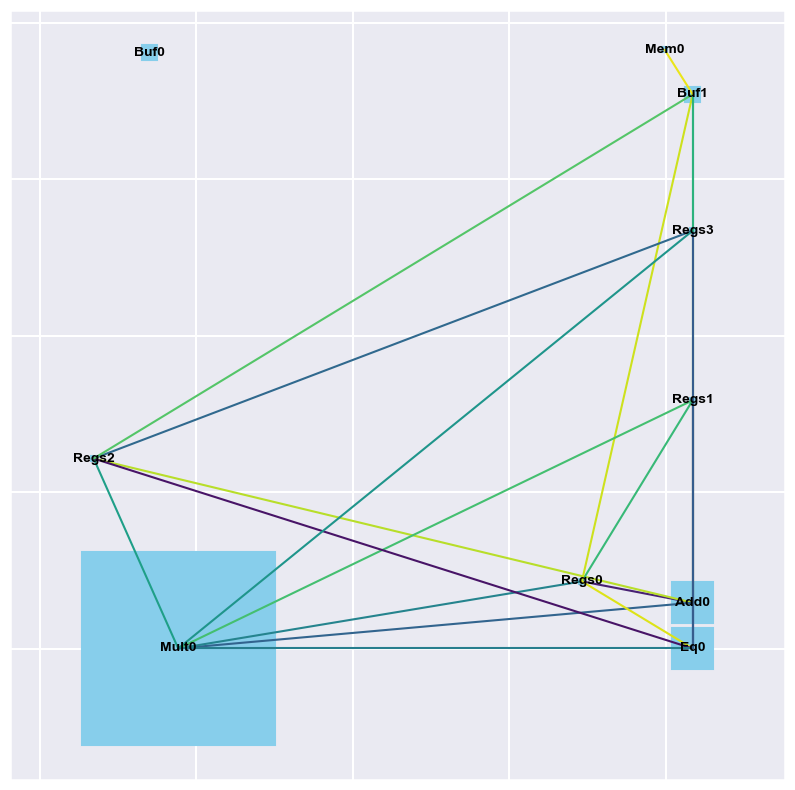

In [87]:
plotter2(optimalPos, areas, nodes, E)

In [81]:
areas

[379348800.0,
 5981433.0,
 5981433.0,
 5981433.0,
 8340007000.0,
 379348800.0,
 50365000.0,
 50365000.0,
 5981433.0,
 5981433.0]

In [97]:
def wrapperAnnealing(cfg='aladdin_const_with_mem'):
    digraph = hw.netlist
    nodes = digraph.nodes
    edges = digraph.edges
    node_to_index = {node: i for i, node in enumerate(nodes)}
    N = len(nodes)
    areas = [None for _ in range(N)]
    newEdges = []
    averageSide = 0
    
    for node in digraph.nodes.data(True):
        name = node[0]
        function = node[1]['function']
        index = node_to_index[name]
        areas[index] = hw.area[function]
        averageSide += areas[index] ** 0.5
        
    for edge in edges:
        if (edge[1], edge[0]) in newEdges:
            continue
    
        newEdges.append(edge)
    
    areas[6] = 50365000.0
    areas[7] = 50365000.0
    averageSide /= N
    E = [(node_to_index[src], node_to_index[dst]) for src, dst in newEdges]
    positions = [(0, 0) for _ in range(N)]
    interval = ((min(areas) / 3.14) ** 0.5, (max(areas) / 3.14) ** 0.5)
    state, c, states, costs, minWireLength, optimalPos, wireLengths = annealing(positions, E, areas, interval, 0.0005, maxsteps=10000)
    plotter2(optimalPos, areas, nodes, E)

wirelength: inf | overlap cost: 1699951499.3907099 | pos: [array([-0.00061913, -0.00027691]), array([0.00092169, 0.00038035]), array([0.00017197, 0.00020748]), array([0.00013875, 0.0002893 ]), array([-1.94204740e-04,  7.53243807e-05]), array([0.00029212, 0.00051384]), array([-0.00084685,  0.00040939]), array([-0.00038724,  0.00015631]), array([ 0.0001968 , -0.00034545]), array([ 0.00014626, -0.00020034])]


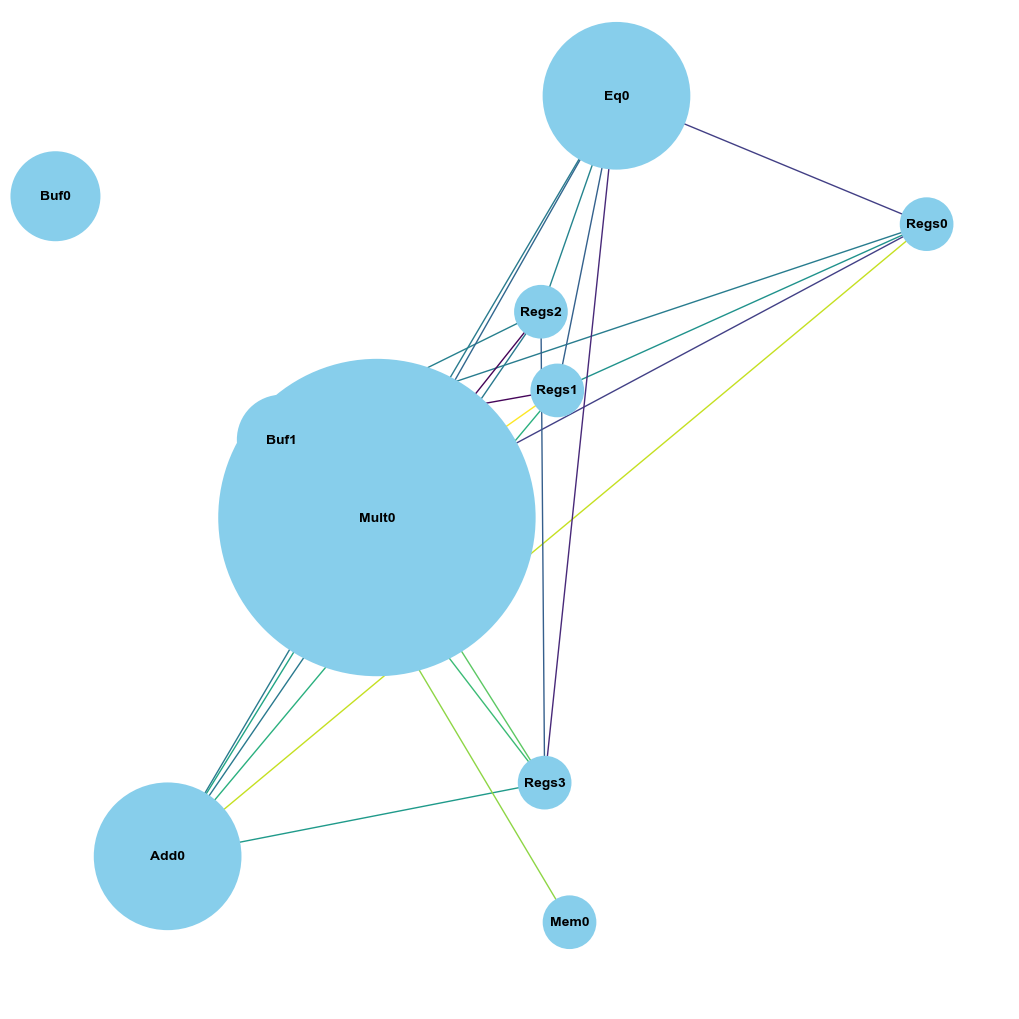

In [98]:
wrapperAnnealing()

In [4]:
from place_and_route import placement
hw = HardwareModel(cfg='simple')

netlist: [('Add0', {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 0}), ('Add1', {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 1}), ('Add2', {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 2}), ('Add3', {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 3}), ('Add4', {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 4}), ('Add5', {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 5}), ('Add6', {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 6}), ('Add7', {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 7}), ('Add8', {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 8}), ('Add9', {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 9}), ('Add10', {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 10}), ('Add11', {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 11}), ('Add12', {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 12}), ('Add13', {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 13}), ('Add14', {'type': 'pe', 'func

wirelength: inf | overlap cost: 54561210.97381596 | pos: [array([-57.32690167,  58.14434418]), array([ 27.19820745, -53.74788528]), array([ 15.19511833, -15.16029969]), array([ -0.2997209 , -22.77085893]), array([-9.41881447, -3.78268232]), array([ 1.05517263, 35.3442497 ]), array([37.21969749, 81.08789083]), array([63.05639865, 34.99874042]), array([-24.63534336,  52.29432726]), array([  0.92647683, -25.9156623 ]), array([-65.23633426, -18.6427779 ]), array([-34.93617466,  22.76204225]), array([30.36950006, 64.40507941]), array([9.36623891, 9.52600524]), array([66.09701212, 29.24330213]), array([-26.42736844,  29.19856403]), array([-21.97063952,  -4.5125388 ]), array([-30.0376275 ,  68.93298563]), array([20.66883591, 19.31675884]), array([-22.47283052, -32.77091857]), array([ -1.4004254 , -13.06937682]), array([ -7.74101128, -39.74717889]), array([-43.26445216,  16.32791362]), array([-13.92488817,  31.60380016]), array([52.25282185,  6.05095219]), array([11.23364185, 83.37224389]), ar

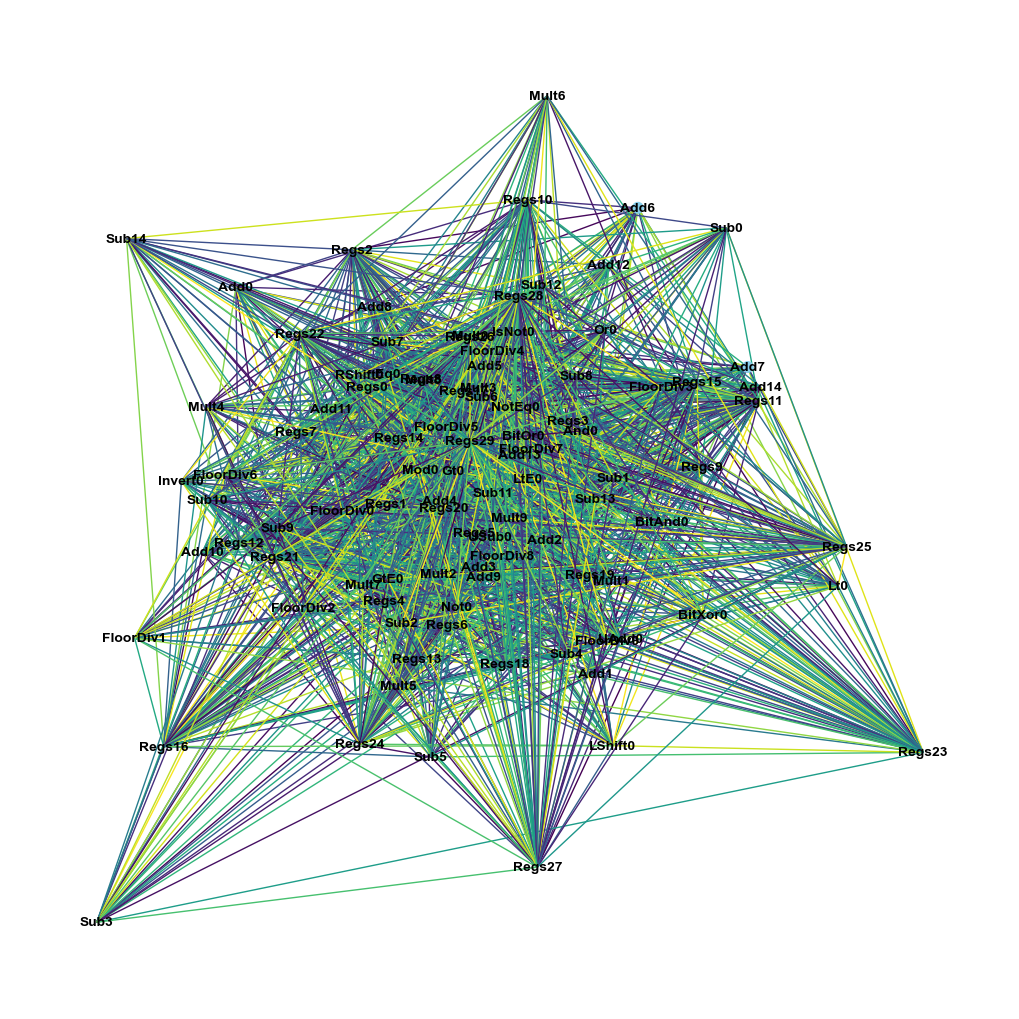

CPU times: user 2h 22min 21s, sys: 4.73 s, total: 2h 22min 25s
Wall time: 2h 22min 41s


([array([-57.32690167,  58.14434418]),
  array([ 27.19820745, -53.74788528]),
  array([ 15.19511833, -15.16029969]),
  array([ -0.2997209 , -22.77085893]),
  array([-9.41881447, -3.78268232]),
  array([ 1.05517263, 35.3442497 ]),
  array([37.21969749, 81.08789083]),
  array([63.05639865, 34.99874042]),
  array([-24.63534336,  52.29432726]),
  array([  0.92647683, -25.9156623 ]),
  array([-65.23633426, -18.6427779 ]),
  array([-34.93617466,  22.76204225]),
  array([30.36950006, 64.40507941]),
  array([9.36623891, 9.52600524]),
  array([66.09701212, 29.24330213]),
  array([-26.42736844,  29.19856403]),
  array([-21.97063952,  -4.5125388 ]),
  array([-30.0376275 ,  68.93298563]),
  array([20.66883591, 19.31675884]),
  array([-22.47283052, -32.77091857]),
  array([ -1.4004254 , -13.06937682]),
  array([ -7.74101128, -39.74717889]),
  array([-43.26445216,  16.32791362]),
  array([-13.92488817,  31.60380016]),
  array([52.25282185,  6.05095219]),
  array([11.23364185, 83.37224389]),
  array(

In [5]:
%time placement(hw)

In [3]:
print(digraph)

DiGraph with 10 nodes and 38 edges


In [4]:
digraph.nodes.data()

NodeDataView({'Add0': {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 0}, 'Regs0': {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'size': 1, 'idx': 0}, 'Regs1': {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'size': 1, 'idx': 1}, 'Regs2': {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'size': 1, 'idx': 2}, 'Mult0': {'type': 'pe', 'function': 'Mult', 'in_use': 0, 'idx': 0}, 'Eq0': {'type': 'pe', 'function': 'Eq', 'in_use': 0, 'idx': 0}, 'Buf0': {'type': 'mem', 'function': 'Buf', 'in_use': 0, 'idx': 0, 'size': 22}, 'Buf1': {'type': 'mem', 'function': 'Buf', 'in_use': 0, 'idx': 1, 'size': 22}, 'Mem0': {'type': 'mem', 'function': 'MainMem', 'in_use': 0, 'idx': 0, 'size': 1024}, 'Regs3': {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'size': 1, 'idx': 3}})